In [10]:
import numpy as np
import numpy as np
import plotly.graph_objects as go
from ipywidgets import widgets
import plotly.graph_objs as go
from ipywidgets import interact

npz_dict = [
    '/home/zlt/Documents/SkydivingPose/sample/labelme/pose_output/output_3D/output_keypoints_3d.npz'
]

all_data = {}
start_frame = 100
for index, npz in enumerate(npz_dict):      # Load the data from the provided .npz file
    data = np.load(npz)
    # Inspect the shape and contents of the 'reconstruction' dataset
    if index in redata_index:
        reconstruction_data = data['reconstruction']
    else:
        reconstruction_data = data['reconstruction']
    
    print(reconstruction_data.shape)
    all_data[index] = reconstruction_data



(165, 17, 3)


In [11]:
# 骨骼连接数据
connections = [
    [0, 1], [1, 2], [2, 3], [0, 4], [4, 5],
    [5, 6], [0, 7], [7, 8], [8, 9], [9, 10],
    [8, 11], [11, 12], [12, 13], [8, 14], [14, 15], [15, 16]
]
# 点的标签


In [12]:
def calculate_angle_between_vectors(v1, v2):
    """Calculate the angle in degrees between two vectors."""
    unit_vector_1 = v1 / np.linalg.norm(v1)
    unit_vector_2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    return np.degrees(angle)


# 添加角度显示到图形中
def add_angle_display(fig, pos1, pos2, pos3, label):

    vector1 = pos2 - pos1
    vector2 = pos2 - pos3
    angle = calculate_angle_between_vectors(vector1, vector2)
    angle_text = f"{angle:.2f}°"

    fig.add_trace(go.Scatter3d(
        x=[pos2[0]],  
        y=[pos2[2]],  # 适应您的轴设置
        z=[-pos2[1]],
        text=[angle_text],
        mode='text',
        textfont=dict(size=20),
        textposition="top center"
    ))

        # 计算中点  
    midpoint1 = (pos1 + pos2) / 2  
    midpoint2 = (pos2 + pos3) / 2  
    
    # 生成链接曲线  
    t = np.linspace(0, 1, 100)  
    curve_x = (1 - t) * midpoint1[0] + t * midpoint2[0]  
    curve_y = (1 - t) * midpoint1[2] + t * midpoint2[2]  # 适应您的轴设置  
    curve_z = -((1 - t) * midpoint1[1] + t * midpoint2[1])  
    
    fig.add_trace(go.Scatter3d(  
        x=curve_x,  
        y=curve_y,  
        z=curve_z,  
        mode='lines',  
        line=dict(color='green', width=2)  
    ))  

# 添加角度显示到图形中
def add_angle_displayV2(fig, pos1, pos2, vector2, label):
    vector1 = pos2 - pos1
    vector2 = vector2
    angle = calculate_angle_between_vectors(vector1, vector2)
    angle_text = f"{angle:.2f}°"
    fig.add_trace(go.Scatter3d(
        x=[pos2[0]],  
        y=[pos2[2]],  # 适应您的轴设置
        z=[-pos2[1]],
        text=[angle_text],
        mode='text',
        textfont=dict(size=20),
        textposition="top center"
    ))

def get_joint_position(data, index):  
    return data[index]  

In [13]:
# 初始化FigureWidget
# 初始化FigureWidget并设置尺寸  
# 初始化FigureWidget并设置尺寸（使用数字而不是字符串）  
fig = go.FigureWidget(  
    layout={  
        'width': 1000,  # 可以调整宽度，例如800, 1000等  
        'height': 1500   # 可以调整高度，例如600, 800等  
    }  
)  

# 设置布局
fig.update_layout(scene=dict(
                    xaxis=dict(title='X'),
                    yaxis=dict(title='Y'),  # 确保y轴垂直方向
                    zaxis=dict(title='Z')
                ))


labels = ['Hips', 'RightThigh', 'RightShin', 'RightFoot', 'LeftThigh', 'LeftShin', 'LeftFoot', 'Spine', 'Neck', 'UpperNeck', 'TopHead', 'LeftShoulder', 'LeftArm', 'LeftHand', 'RightShoulder', 'RightArm', 'RightHand']
# 确保颜色被定义为字符串形式的rgb  
colors_dict = {  
    0: 'rgb(255, 0, 0)',    # 红色  
    1: 'rgb(255, 165, 0)',  # 橙色  
    2: 'rgb(255, 255, 0)',  # 黄色  
    3: 'rgb(0, 128, 0)',    # 绿色  
    4: 'rgb(0, 0, 255)',    # 蓝色  
    5: 'rgb(128, 0, 128)'   # 紫色  
}  

In [14]:
import numpy as np  

def align_left_right_thigh_per_frame(data, labels):  
    """  
    Align the LeftThigh-RightThigh line to the x-axis direction for each frame.  
    
    :param data: The skeleton dataset for all frames, a numpy array of shape (n_frames, n_joints, 3).  
    :param labels: List of joint labels to identify the indices for LeftThigh and RightThigh.  
    :return: The aligned dataset for each frame.  
    """  
    # 找到 'LeftThigh' 和 'RightThigh' 的索引  
    left_thigh_index = labels.index('LeftThigh')  
    right_thigh_index = labels.index('RightThigh')  

    # 对每一帧的数据进行对齐  
    for frame in range(data.shape[0]):  
        # 计算大腿向量  
        thigh_vector = data[frame, left_thigh_index] - data[frame, right_thigh_index]  
        # 标准化大腿向量  
        thigh_vector /= np.linalg.norm(thigh_vector)  

        # 目标 x 轴方向  
        target_vector_x = np.array([1, 0, 0])  
        
        # 计算旋转轴（即大腿向量与目标向量的叉积）  
        axis = np.cross(thigh_vector, target_vector_x)  
        
        # 如果轴的模量非常小，意味着已经对齐或几乎对齐  
        if np.linalg.norm(axis) > 1e-6:  
            # 归一化旋转轴  
            axis /= np.linalg.norm(axis)  
            # 计算旋转角度  
            angle = np.arccos(np.clip(np.dot(thigh_vector, target_vector_x), -1.0, 1.0))  
            # 计算旋转矩阵  
            K = np.array([[0, -axis[2], axis[1]], [axis[2], 0, -axis[0]], [-axis[1], axis[0], 0]])  
            rotation_matrix = np.eye(3) + np.sin(angle) * K + (1 - np.cos(angle)) * np.dot(K, K)  
            
            # 应用旋转矩阵到当前帧的骨架数据  
            data[frame] = np.dot(data[frame], rotation_matrix.T)  

    return data

In [15]:
# 确保定义了每个关节对应的标签列表  
labels = ['Hips', 'RightThigh', 'RightShin', 'RightFoot', 'LeftThigh', 'LeftShin', 'LeftFoot', 'Spine', 'Neck', 'UpperNeck', 'TopHead', 'LeftShoulder', 'LeftArm', 'LeftHand', 'RightShoulder', 'RightArm', 'RightHand']


# 对每个数据集进行对齐  
aligned_data = {key: align_left_right_thigh_per_frame(data, labels) for key, data in all_data.items()}  

print("Alignment complete. Ready for further visualization or analysis.")

Alignment complete. Ready for further visualization or analysis.


In [16]:
print(aligned_data[0].shape)

(165, 17, 3)


In [17]:
all_data = aligned_data

In [18]:
import plotly.graph_objects as go  
import numpy as np  
import ipywidgets as widgets  
from IPython.display import display  

# 假设相关的数据和函数已定义，包括 npz_dict, colors, labels, get_joint_position。  

# 初始化图形  
fig = go.FigureWidget(  
    layout={  
        'width': 1000,  # 可以调整宽度，例如800, 1000等  
        'height': 1000   # 可以调整高度，例如600, 800等  
    }  
)  

# 更新你的 display_3D 函数，确保颜色作为字符串传递给 plotly  
def display_3D(reconstruction_data, show_color, visible=True, index=0):  
    frame_data = reconstruction_data[index]  
    for connection in connections:  
        x = [frame_data[connection[0], 0], frame_data[connection[1], 0]]  
        y = [frame_data[connection[0], 2], frame_data[connection[1], 2]]  
        z = [-frame_data[connection[0], 1], -frame_data[connection[1], 1]]  
        fig.add_trace(go.Scatter3d(  
            x=x, y=y, z=z,   
            mode='lines',   
            line=dict(color=show_color),   
            showlegend=False  
        ))  
    
    for i, label in enumerate(labels):  
        fig.add_trace(go.Scatter3d(  
            x=[frame_data[i, 0]],  
            y=[frame_data[i, 2]],  
            z=[-frame_data[i, 1]],  
            mode='markers',  
            marker=dict(size=10, color=show_color),  
            name=label,  
        ))  

    # 示例：计算并显示大腿和小腿的角度
    right_thigh_pos = get_joint_position(frame_data, labels.index('RightThigh'))
    right_shin_pos = get_joint_position(frame_data, labels.index('RightShin'))
    right_foot_pos = get_joint_position(frame_data, labels.index('RightFoot'))
    
    add_angle_display(fig, right_thigh_pos, right_shin_pos, right_foot_pos, "Right Leg")

    # 示例：计算并显示大腿和小腿的角度
    Hips_pos = get_joint_position(frame_data, labels.index('Hips'))
    Head_pos = get_joint_position(frame_data, labels.index('Neck'))
    vertical_vector =  np.array([0, 1, 0])  # 取默认的垂直向量 
    
    add_angle_displayV2(fig, Head_pos, Hips_pos, vertical_vector, "Body")
    
# 清空图形数据的函数  
def clear_figure():  
    fig.data = []  


# Apply alignment to all datasets  
# aligned_data = [align_left_right_thigh_per_frame(data, labels) for data in all_data]  

# 按钮的回调函数  
# 继续使用到 update_display 函数会使用这些颜色  
def update_display(change):  
    clear_figure()  
    selected_indices = [i for i, toggle in enumerate(toggles) if toggle.value]  
    for index in selected_indices:  
        display_3D(all_data[index], show_color=colors_dict[index], visible=True, index=slider.value)  

# 创建每个数据集的ToggleButtons  
toggles = [widgets.ToggleButton(value=True, description=f'Data {i+1}', button_style='', layout=widgets.Layout(width='100px')) for i in range(len(npz_dict))]  

# 为每个按钮添加观察者  
for toggle in toggles:  
    toggle.observe(update_display, names='value')  

# 创建滑块  
slider = widgets.IntSlider(min=0, max=reconstruction_data.shape[0] - 1, step=1, value=0)  
slider.observe(update_display, names='value')  

# 水平排列的ToggleButtons  
toggle_box = widgets.HBox(toggles)  

# 显示所有小部件和图形  
display(toggle_box, slider, fig)  

# 执行初始渲染  
update_display(None)

IntSlider(value=0, max=164)

FigureWidget({
    'data': [], 'layout': {'height': 1000, 'template': '...', 'width': 1000}
})

In [39]:
import numpy as np  

# 假设这是您关节的标签列表，可以根据它们来获取每个关节的索引  
labels = ['Hips', 'RightThigh', 'RightShin', 'RightFoot', 'LeftThigh', 'LeftShin', 'LeftFoot',   
          'Spine', 'Neck', 'UpperNeck', 'TopHead', 'LeftShoulder', 'LeftArm', 'LeftHand',   
          'RightShoulder', 'RightArm', 'RightHand']  

# 从labels中得到每个关节的索引  
right_shin_index = labels.index('RightShin')  
right_foot_index = labels.index('RightFoot')  
left_shin_index = labels.index('LeftShin')  
left_foot_index = labels.index('LeftFoot')  
spine_index = labels.index('Spine')  
neck_index = labels.index('Neck')  
upper_neck_index = labels.index('UpperNeck')  
top_head_index = labels.index('TopHead')  

# 选择第一个和第三个数据集进行操作  
index1 = 1  # 第一个数据集的索引  
index3 = 3  # 第三个数据集的索引  

data1 = all_data[index1]  # 从第一个数据集提取数据  
data3 = all_data[index3]  # 从第三个数据集提取数据  

# 使用第一个数据集的时间帧  
n_frames = 30  # 获取时间帧数量  
n_joints = len(labels)     # 关节数量  

# 初始化新的骨架数据  
new_skeleton = np.zeros((n_frames, n_joints, 3))  

for frame in range(n_frames):  
    # 取其他关键点从第一个数据集  
    new_skeleton[frame] = data1[frame]  
    
    # 从第三个数据集中获取 right_shin 和 right_foot  
    new_skeleton[frame, right_shin_index] = data3[frame, right_shin_index]  
    new_skeleton[frame, right_foot_index] = data3[frame, right_foot_index]  

    # 从第三个数据集中获取 left_shin 和 left_foot  
    new_skeleton[frame, left_shin_index] = data3[frame, left_shin_index]  
    new_skeleton[frame, left_foot_index] = data3[frame, left_foot_index]  

    # spine, neck, upper_neck, top_head 的均值计算   
    new_skeleton[frame, spine_index] = (data1[frame, spine_index] + data3[frame, spine_index]) / 2  
    new_skeleton[frame, neck_index] = (data1[frame, neck_index] + data3[frame, neck_index]) / 2  
    new_skeleton[frame, upper_neck_index] = (data1[frame, upper_neck_index] + data3[frame, upper_neck_index]) / 2  
    new_skeleton[frame, top_head_index] = (data1[frame, top_head_index] + data3[frame, top_head_index]) / 2  

print("New skeleton has been created with shape:", new_skeleton.shape)

New skeleton has been created with shape: (30, 17, 3)


In [40]:
import plotly.graph_objects as go  
import numpy as np  
import ipywidgets as widgets  
from IPython.display import display  

# 假设相关的数据和函数已定义，包括 npz_dict, colors, labels, get_joint_position。  

# 初始化图形  
fig = go.FigureWidget(  
    layout={  
        'width': 1000,  # 可以调整宽度，例如800, 1000等  
        'height': 1000   # 可以调整高度，例如600, 800等  
    }  
)  

# 更新你的 display_3D 函数，确保颜色作为字符串传递给 plotly  
def display_3D(reconstruction_data, show_color, visible=True, index=0):  
    frame_data = reconstruction_data[index]  
    for connection in connections:  
        x = [frame_data[connection[0], 0], frame_data[connection[1], 0]]  
        y = [frame_data[connection[0], 2], frame_data[connection[1], 2]]  
        z = [-frame_data[connection[0], 1], -frame_data[connection[1], 1]]  
        fig.add_trace(go.Scatter3d(  
            x=x, y=y, z=z,   
            mode='lines',   
            line=dict(color=show_color),   
            showlegend=False  
        ))  
    
    for i, label in enumerate(labels):  
        fig.add_trace(go.Scatter3d(  
            x=[frame_data[i, 0]],  
            y=[frame_data[i, 2]],  
            z=[-frame_data[i, 1]],  
            mode='markers',  
            marker=dict(size=10, color=show_color),  
            name=label,  
        ))  

    # 示例：计算并显示大腿和小腿的角度
    right_thigh_pos = get_joint_position(frame_data, labels.index('RightThigh'))
    right_shin_pos = get_joint_position(frame_data, labels.index('RightShin'))
    right_foot_pos = get_joint_position(frame_data, labels.index('RightFoot'))
    
    add_angle_display(fig, right_thigh_pos, right_shin_pos, right_foot_pos, "Right Leg")

    # 示例：计算并显示大腿和小腿的角度
    Hips_pos = get_joint_position(frame_data, labels.index('Hips'))
    Head_pos = get_joint_position(frame_data, labels.index('Neck'))
    vertical_vector =  np.array([0, 1, 0])  # 取默认的垂直向量 
    
    add_angle_displayV2(fig, Head_pos, Hips_pos, vertical_vector, "Body")
    
# 清空图形数据的函数  
def clear_figure():  
    fig.data = []  


# Apply alignment to all datasets  
# aligned_data = [align_left_right_thigh_per_frame(data, labels) for data in all_data]  

# 按钮的回调函数  
# 继续使用到 update_display 函数会使用这些颜色  
def update_display(change):  
    clear_figure()  
    selected_indices = [i for i, toggle in enumerate(toggles) if toggle.value]  
    display_3D(new_skeleton, show_color=colors_dict[index], visible=True, index=slider.value)  

# 创建每个数据集的ToggleButtons  
toggles = [widgets.ToggleButton(value=True, description=f'Data {i+1}', button_style='', layout=widgets.Layout(width='100px')) for i in range(len(npz_dict))]  

# 为每个按钮添加观察者  
for toggle in toggles:  
    toggle.observe(update_display, names='value')  

# 创建滑块  
slider = widgets.IntSlider(min=0, max=reconstruction_data.shape[0] - 1, step=1, value=0)  
slider.observe(update_display, names='value')  

# 水平排列的ToggleButtons  
toggle_box = widgets.HBox(toggles)  

# 显示所有小部件和图形  
display(toggle_box, slider, fig)  

# 执行初始渲染  
update_display(None)

IntSlider(value=0, max=82)

FigureWidget({
    'data': [], 'layout': {'height': 1000, 'template': '...', 'width': 1000}
})

IndexError: index 53 is out of bounds for axis 0 with size 30

IndexError: index 55 is out of bounds for axis 0 with size 30

IndexError: index 57 is out of bounds for axis 0 with size 30

IndexError: index 55 is out of bounds for axis 0 with size 30

IndexError: index 30 is out of bounds for axis 0 with size 30

KeyError: 1

MovieWriter imagemagick unavailable; using Pillow instead.


{'S1': {'54138969': {'R': array([[-0.91536173,  0.05154812, -0.39931903],
       [ 0.40180837,  0.18037357, -0.89778361],
       [ 0.02574754, -0.98224649, -0.18581953]]), 'T': array([[1841.10702775],
       [4955.28462345],
       [1563.4453959 ]]), 'c': array([[512.54150496],
       [515.45148698]]), 'f': array([[1145.04940459],
       [1143.78109572]]), 'k': array([[-0.20709891],
       [ 0.24777518],
       [-0.00307515]]), 'p': array([[-0.00142447],
       [-0.0009757 ]]), 'azimuth': 70}, '55011271': {'R': array([[ 0.92816834,  0.08166409, -0.36309022],
       [ 0.37215384, -0.1977723 ,  0.90685591],
       [ 0.00224838, -0.97684036, -0.21395759]]), 'T': array([[ 1761.27853428],
       [-5078.00659454],
       [ 1606.26495983]]), 'c': array([[508.84862165],
       [508.06491709]]), 'f': array([[1149.67569987],
       [1147.59161667]]), 'k': array([[-0.19421363],
       [ 0.24040854],
       [ 0.00681998]]), 'p': array([[-0.00274089],
       [-0.00161903]]), 'azimuth': -70}, '58860

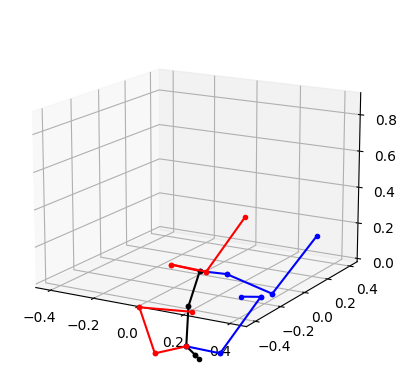

In [41]:
from pathlib import Path
import os
import sys
from IPython.display import HTML
sys.path.append("../")
from app.bvh_skeleton import openpose_skeleton, h36m_skeleton, cmu_skeleton
from app.utils import smooth, vis, bvh_camera

output_dir = Path("/home/zlt/Documents/SkydivingPose/output/bvh")


subject = 'S1'
cam_id = '54138969'
cdata = bvh_camera.load_camera_params('cameras.h5')
print(cdata)
cam_params = cdata[subject][cam_id]
R = cam_params['R']
T = 0
azimuth = cam_params['azimuth']

pose3d_world = bvh_camera.camera2world(pose=new_skeleton, R=R, T=T)
pose3d_world[:, :, 2] -= np.min(pose3d_world[:, :, 2]) # rebase the height

pose3d_file = output_dir / '3d_pose.npy'
np.save(pose3d_file, pose3d_world)


h36m_skel = h36m_skeleton.H36mSkeleton()
gif_file = output_dir / '3d_pose_300.gif' # output format can be .gif or .mp4 

ani = vis.vis_3d_keypoints_sequence(
    keypoints_sequence=new_skeleton[0:30],
    skeleton=h36m_skel,
    azimuth=None,
    fps=60,
    output_file=gif_file
)
HTML(ani.to_jshtml())

In [42]:
video_file = "demo"
bvh_file = output_dir / f'{video_file}.bvh'
cmu_skel = cmu_skeleton.CMUSkeleton()
channels, header = cmu_skel.poses2bvh(pose3d_world, output_file=bvh_file)

In [43]:
output = output_dir / 'h36m_cxk.bvh'
h36m_skel = h36m_skeleton.H36mSkeleton()
_ = h36m_skel.poses2bvh(pose3d_world, output_file=output)